*   OBJECTIVE: identify and classify toxic online comments
*   DATASET: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
*   MODEL: LSTM with 3 layers
*   OUTCOME: accuracy of 96.83% achieved on the validation dataset

In [ ]:
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
batch_size_train = 32
batch_size_val = 32

In [ ]:
MAX_SENTENCE_LEN = 100
MAX_NUM_WORDS = 20000

In [ ]:
device = torch.device("cuda:0")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -uq "/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/*.zip" -d "/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge"


4 archives were successfully processed.


In [ ]:
# read data
train_dataset = pd.read_csv('/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/train.csv')
# shuffle train examples
train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
train_dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,5e7b93f9c84088fc,"""\n\n Possibly unfree File:Sheppey Experiment ...",0,0,0,0,0,0
1,018713a1b9f0252f,you deliberately ignored my point 1) above for...,0,0,0,0,0,0
2,f1b0160382cf2147,Hey there! I will indeed check that book - tha...,0,0,0,0,0,0
3,9a5044cb1014f4b9,uhhh \n\nTaco bell is on me is a slogan where ...,0,0,0,0,0,0
4,c1d4e6c1a557b15b,I would make the case that you are vandalizing...,0,0,0,0,0,0


In [ ]:
# split train dataset into train and validation
train_set, val_set = train_dataset['comment_text'][:125000], train_dataset['comment_text'][125000:]

y = np.array(train_dataset[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].iloc[:])
y_train, y_val = y[:125000], y[125000:]

# initializing the Tokenizer class                                                   
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
# updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(train_set)

# convert text comments to numerical sequences
train_seq = tokenizer.texts_to_sequences(train_set)
val_seq = tokenizer.texts_to_sequences(val_set)

word_index = tokenizer.word_index
print("Length of word Index:", len(word_index))
print("First 5 elements in the word_index dictionary:", dict(list(word_index.items())[0: 5]) )
print("First comment text in training set:\n", train_dataset['comment_text'][0], "\n", train_seq[0])


Length of word Index: 180621
First 5 elements in the word_index dictionary: {'the': 1, 'to': 2, 'of': 3, 'and': 4, 'a': 5}
First comment text in training set:
 "

 Possibly unfree File:Sheppey Experiment (Dry Brush - G&M; adjustments)-final-web- copy.jpg 
An image that you uploaded or altered, File:Sheppey Experiment (Dry Brush - G&M; adjustments)-final-web- copy.jpg, has been listed at Wikipedia:Possibly unfree images because its copyright status is unclear or disputed. If the image's copyright status cannot be verified, it may be deleted. You may find more information on the image description page. You are welcome to add comments to its entry at the discussion if you are interested in it not being deleted. Thank you.  (talk)    (talk) " 
 [987, 4438, 510, 1274, 5390, 11164, 715, 874, 9870, 1087, 531, 746, 461, 30, 119, 9, 6, 694, 25, 1953, 510, 1274, 5390, 11164, 715, 874, 9870, 1087, 531, 746, 461, 43, 54, 422, 34, 29, 987, 4438, 343, 68, 107, 247, 660, 8, 2249, 25, 1652, 22, 1, 598

In [ ]:
# pad tokenized sequences

train_seq = pad_sequences(train_seq, maxlen=MAX_SENTENCE_LEN)
val_seq = pad_sequences(val_seq, maxlen=MAX_SENTENCE_LEN)

In [ ]:
# create custom dataset class 

class TextDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]


In [ ]:
# use DataLoaders to handle the data

train_dataset = TextDataset(train_seq, y_train)
val_dataset = TextDataset(val_seq, y_val)

train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train)
val_loader =  torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_val)

In [ ]:
# define a model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3 

        self.embedding = nn.Embedding(MAX_NUM_WORDS, self.embedding_dim)

        self.lstm = nn.LSTM( 
            input_size=MAX_SENTENCE_LEN,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2, 
            batch_first=True)
        
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, 6)
        
    def forward(self, x):     
        s = nn.Sigmoid()
    
        x = torch.LongTensor(x.cpu().detach().numpy()).to(device)
        x = self.embedding(x)
        
        x = torch.Tensor(np.moveaxis(x.cpu().detach().numpy(), 1, -1)).to(device)
        
        output, _ = self.lstm(x)
        
        x = F.relu(output[:, :, -1])
        x = F.relu(self.fc1(x))
        x = s(self.fc2(x))
        
        return x

In [ ]:
# a function to calculate accuracy

def calculate_accuracy(pred, target, threshold=0.5):
    pred = pred.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
  
    pred = np.array(pred >= threshold, dtype=float)
  
    return np.sum(pred==target)/(pred.shape[0]*6)

In [ ]:
# a function that runs a training process for the neural network

def train(model, train_loader):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)    
    criterion = torch.nn.BCELoss()
    # to reduce learning rate on plateau the corresponding scheduler is applied
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)

    epochs = 10
    epoch_train_loss = [0]*epochs
    epoch_val_loss = [0]*epochs
    epoch_accuracy = [0]*epochs
        
    train_losses = []
    train_counter = []
    log_interval = 120
    
    for e in range(epochs):

        running_loss = 0
        running_accuracy = 0
        
        for batch_idx, (embeddings, labels) in enumerate(train_loader):
          
            embeddings, labels = embeddings.to(device), labels.to(device)

            optimizer.zero_grad()
         
            output = model(embeddings)
            loss = criterion(output, labels.float())

            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch_idx % log_interval == 0:
                train_losses.append(loss.item())
                train_counter.append((batch_idx*batch_size_train) + (e*len(train_loader.dataset)))
                
            running_accuracy += calculate_accuracy(output, labels)

        val_loss, val_acc = test(model, val_loader)

        scheduler.step(val_loss)
        
        epoch_val_loss[e] = val_loss
        epoch_train_loss[e] = running_loss/len(train_loader)
        epoch_accuracy[e] = running_accuracy/len(train_loader)
        
        print("Epoch {} \n Training: loss - {}, accuracy - {} \n Validation: loss - {}, accuracy - {}"
              .format(e, epoch_train_loss[e], epoch_accuracy[e], val_loss, val_acc))
        
    
    sns.set(style="whitegrid", font_scale=1.4)

    fig, (ax1, ax2) = plt.subplots(1,2)

    fig.set_figwidth(20)
    fig.set_figheight(7)

    ax1.plot(epoch_train_loss, label='train')
    ax1.plot(epoch_val_loss, label='validation')
    ax2.plot(train_counter, train_losses)
    
    ax1.set(xlabel="Epoch", ylabel="Loss")
    ax2.set(xlabel="Number of training examples seen", ylabel="Loss")
    ax1.legend()


In [ ]:
# this function calculates a loss value on the validation dataset

def test(model, val_loader):
    criterion = torch.nn.BCELoss()
    running_loss = 0
    running_accuracy = 0

    for embeddings, labels in val_loader:
        with torch.no_grad():
          
            embeddings, labels = embeddings.to(device), labels.to(device)
            output = model(embeddings)
            
            running_loss += criterion(output, labels.float())
            running_accuracy += calculate_accuracy(output, labels)
            
    running_loss /= len(val_loader)
    running_accuracy /= len(val_loader)
    
    return running_loss, running_accuracy

In [ ]:
net = Net()
net.to(device)

Net(
  (embedding): Embedding(20000, 128)
  (lstm): LSTM(100, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)

Epoch 0 
 Training: loss - 0.1414210419488786, accuracy - 0.9623658924153229 
 Validation: loss - 0.13169929385185242, accuracy - 0.9640169035404922
Epoch 1 
 Training: loss - 0.12084738916586603, accuracy - 0.9640895614708642 
 Validation: loss - 0.11377004534006119, accuracy - 0.9658670423009
Epoch 2 
 Training: loss - 0.10919071497581088, accuracy - 0.9665664192475041 
 Validation: loss - 0.10582496225833893, accuracy - 0.9673654619740425
Epoch 3 
 Training: loss - 0.10483348548759394, accuracy - 0.9675568957426834 
 Validation: loss - 0.10487232357263565, accuracy - 0.967558184761584
Epoch 4 
 Training: loss - 0.10188028985781761, accuracy - 0.9682767575292209 
 Validation: loss - 0.10256865620613098, accuracy - 0.968396966893729
Epoch 5 
 Training: loss - 0.09915536068454252, accuracy - 0.9691725855302432 
 Validation: loss - 0.10170485824346542, accuracy - 0.9687193395565281
Epoch 6 
 Training: loss - 0.09648451050312006, accuracy - 0.9697484749594748 
 Validation: loss - 0.10123

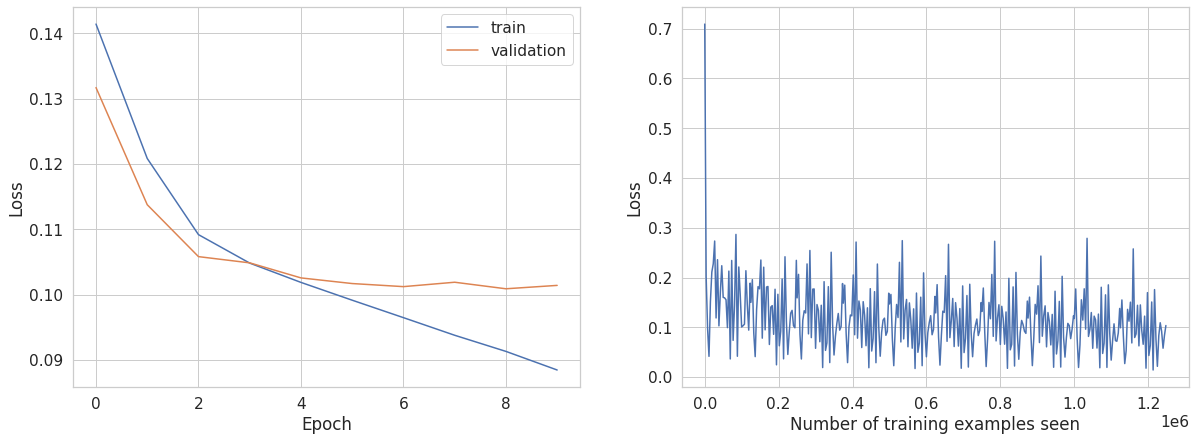

In [ ]:
train(net, train_loader)